<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parallelization" data-toc-modified-id="Parallelization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parallelization</a></span><ul class="toc-item"><li><span><a href="#Multiprocessing-client" data-toc-modified-id="Multiprocessing-client-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Multiprocessing client</a></span></li><li><span><a href="#Ipyparallel-client" data-toc-modified-id="Ipyparallel-client-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ipyparallel client</a></span><ul class="toc-item"><li><span><a href="#Running-parallel-inference-with-ipyparallel" data-toc-modified-id="Running-parallel-inference-with-ipyparallel-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Running parallel inference with ipyparallel</a></span></li></ul></li><li><span><a href="#Working-interactively-with-ipyparallel" data-toc-modified-id="Working-interactively-with-ipyparallel-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Working interactively with ipyparallel</a></span><ul class="toc-item"><li><span><a href="#Remember-to-stop-the-ipcluster-when-done" data-toc-modified-id="Remember-to-stop-the-ipcluster-when-done-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Remember to stop the ipcluster when done</a></span></li></ul></li></ul></li></ul></div>

This tutorial is generated from a [Jupyter](http://jupyter.org/) notebook that can be found [here](https://github.com/elfi-dev/notebooks).

# Parallelization

Behind the scenes, ELFI can automatically parallelize the computational inference via different clients. Currently ELFI includes three clients:

- `elfi.clients.native` (activated by default): does not parallelize but makes it easy to test and debug your code.
- `elfi.clients.multiprocessing`: basic local parallelization using Python's built-in multiprocessing library
- `elfi.clients.ipyparallel`: [ipyparallel](http://ipyparallel.readthedocs.io/) based client that can parallelize from multiple cores up to a distributed cluster.

A client is activated by giving the name of the client to `elfi.set_client`.

This tutorial shows how to activate and use the `multiprocessing` or `ipyparallel` client with ELFI. The `ipyparallel` client supports parallelization from local computer up to a cluster environment. For local parallelization however, the `multiprocessing` client is simpler to use. Let's begin by importing ELFI and our example MA2 model from the tutorial.

In [1]:
import elfi
from elfi.examples import ma2

Let's get the model and plot it (requires graphviz)

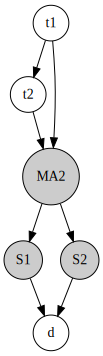

In [3]:
model = ma2.get_model()
elfi.draw(model)

## Multiprocessing client

The multiprocessing client allows you to easily use the cores available in your computer. You can activate it simply by

In [4]:
elfi.set_client('multiprocessing')

Any inference instance created **after** you have set the new client will automatically use it to perform the computations. Let's try it with our MA2 example model from the tutorial. When running the next command, take a look at the system monitor of your operating system; it should show that all of your cores are doing heavy computation simultaneously.

In [5]:
rej = elfi.Rejection(model, 'd', batch_size=10000, seed=20170530)
%time result = rej.sample(5000, n_sim=int(1e6))  # 1 million simulations

CPU times: user 298 ms, sys: 25.7 ms, total: 324 ms
Wall time: 3.93 s


And that is it. The result object is also just like in the basic case:

Method: Rejection
Number of samples: 5000
Number of simulations: 1000000
Threshold: 0.0826
Sample means: t1: 0.694, t2: 0.226


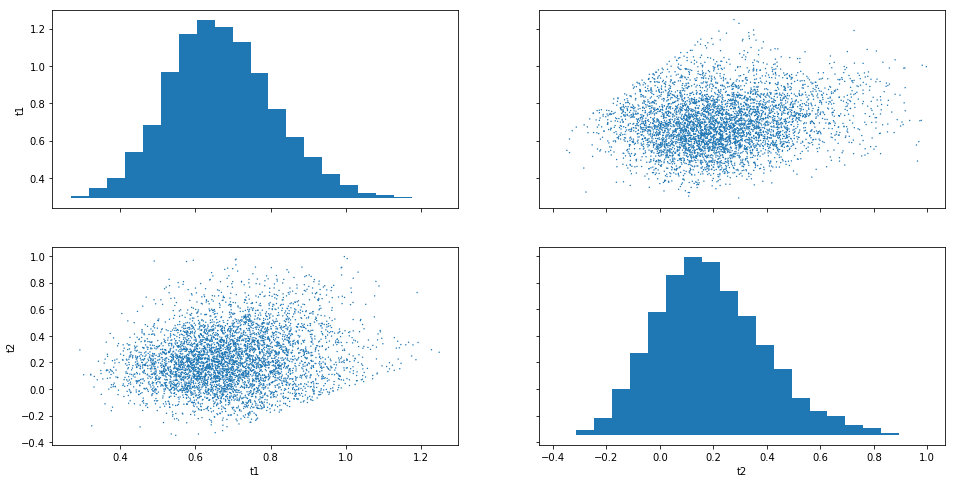

In [6]:
# Print the summary
result.summary()

import matplotlib.pyplot as plt
result.plot_pairs();
plt.show()

Note that for reproducibility a reference to the activated client is saved in the inference instance:

In [6]:
rej.client

If you want to change the client for an existing inference instance, you have to do something like this:

In [7]:
elfi.set_client('native')
rej.client = elfi.get_client()
rej.client

By default the multiprocessing client will use all cores on your system. This is not always desirable, as the operating system may prioritize some other process, leaving ELFI queuing for the promised resources. You can define some other number of processes like so:

In [8]:
elfi.set_client(elfi.clients.multiprocessing.Client(num_processes=3))

**Note:** The `multiprocessing` library may require additional care under Windows. If you receive a RuntimeError mentioning `freeze_support`, please include a call to `multiprocessing.freeze_support()`, see [documentation](https://docs.python.org/3.6/library/multiprocessing.html#multiprocessing.freeze_support).

## Ipyparallel client

The `ipyparallel` client allows you to parallelize the computations to cluster environments. To use the `ipyparallel` client, you first have to create an `ipyparallel` cluster. Below is an example of how to start a local cluster to the background using 4 CPU cores:

In [9]:
!ipcluster start -n 4 --daemon

# This is here just to ensure that ipcluster has enough time to start properly before continuing
import time
time.sleep(10)

.. note:: The exclamation mark above is a Jupyter syntax for executing shell commands. You can run the same command in your terminal without the exclamation mark.

.. tip:: Please see the ipyparallel documentation (https://ipyparallel.readthedocs.io/en/latest/intro.html#getting-started) for more information and details for setting up and using ipyparallel clusters in different environments.

### Running parallel inference with ipyparallel

After the cluster has been set up, we can proceed as usual. ELFI will take care of the parallelization from now on:

In [10]:
# Let's start using the ipyparallel client
elfi.set_client('ipyparallel')

rej = elfi.Rejection(model, 'd', batch_size=10000, seed=20170530)
%time result = rej.sample(5000, n_sim=int(5e6))  # 5 million simulations

 /home/leclercq/.local/apps/anaconda/2-4.3.1/install/envs/py36/lib/python3.6/site-packages/ipyparallel/client/client.py:458: RuntimeWarning:
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@pinacolada')
            or instruct your controller to listen on an external IP.


CPU times: user 3.47 s, sys: 288 ms, total: 3.76 s
Wall time: 18.1 s


To summarize, the only thing that needed to be changed from the basic scenario was creating the `ipyparallel` cluster and enabling the `ipyparallel` client.

## Working interactively with ipyparallel

If you are using the `ipyparallel` client from an interactive environment (e.g. jupyter notebook) there are some things to take care of. All imports and definitions must be visible to all `ipyparallel` engines. You can ensure this by writing a script file that has all the definitions in it. In a distributed setting, this file must be present in all remote workers running an `ipyparallel` engine. 

However, you may wish to experiment in an interactive session, using e.g. a jupyter notebook. `ipyparallel` makes it possible to interactively define functions for ELFI model and send them to workers. This is especially useful if you work from a jupyter notebook. We will show a few examples. More information can be found from [`ipyparallel` documentation](http://ipyparallel.readthedocs.io/). 

In interactive sessions, you can change the model with built-in functionality without problems:

In [11]:
d2 = elfi.Distance('cityblock', model['S1'], model['S2'], p=1)

rej2 = elfi.Rejection(d2, batch_size=10000)
result2 = rej2.sample(1000, quantile=0.01)

Method: Rejection
Number of samples: 1000
Number of simulations: 100000
Threshold: 0.146
Sample means: t1: 0.543, t2: 0.263


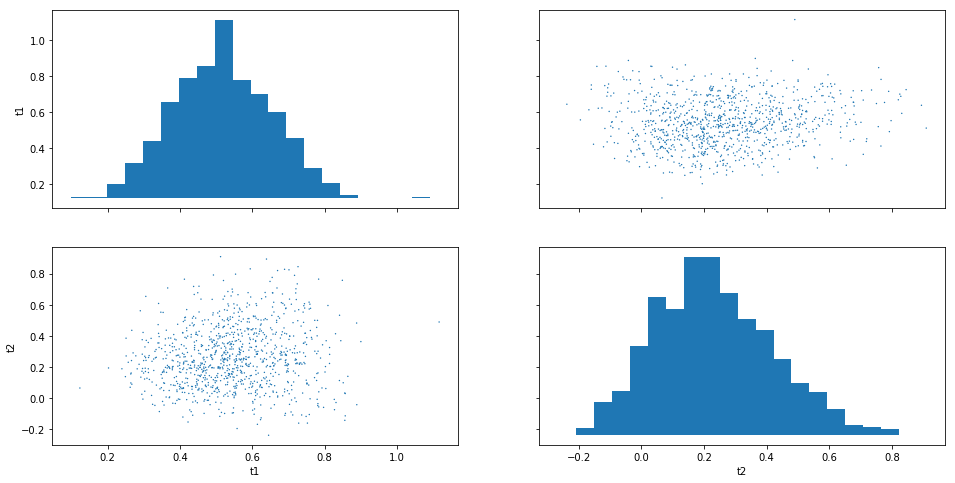

In [10]:
# Print the summary
result2.summary()

import matplotlib.pyplot as plt
result2.plot_pairs();
plt.show()

But let's say you want to use your very own distance function in a jupyter notebook:

In [12]:
def my_distance(x, y):
    # Note that interactively defined functions must use full module names, e.g. numpy instead of np
    return numpy.sum((x-y)**2, axis=1)

d3 = elfi.Distance(my_distance, model['S1'], model['S2'])
rej3 = elfi.Rejection(d3, batch_size=10000)

This function definition is not automatically visible for the `ipyparallel` engines if it is not defined in a physical file. The engines run in different processes and will not see interactively defined objects and functions. The below would therefore fail:

In [13]:
# This will fail if you try it!
# result3 = rej3.sample(1000, quantile=0.01)

Ipyparallel provides a way to manually `push` the new definition to the scopes of the engines from interactive sessions. Because `my_distance` also uses `numpy`, that must be imported in the engines as well:

In [14]:
# Get the ipyparallel client
ipyclient = elfi.get_client().ipp_client

# Import numpy in the engines (note that you cannot use "as" abbreviations, but must use plain imports)
with ipyclient[:].sync_imports():
    import numpy

# Then push my_distance to the engines
ipyclient[:].push({'my_distance': my_distance});

importing numpy on engine(s)


The above may look a bit cumbersome, but now this works:

Method: Rejection
Number of samples: 1000
Number of simulations: 100000
Threshold: 0.0143
Sample means: t1: 0.544, t2: 0.271


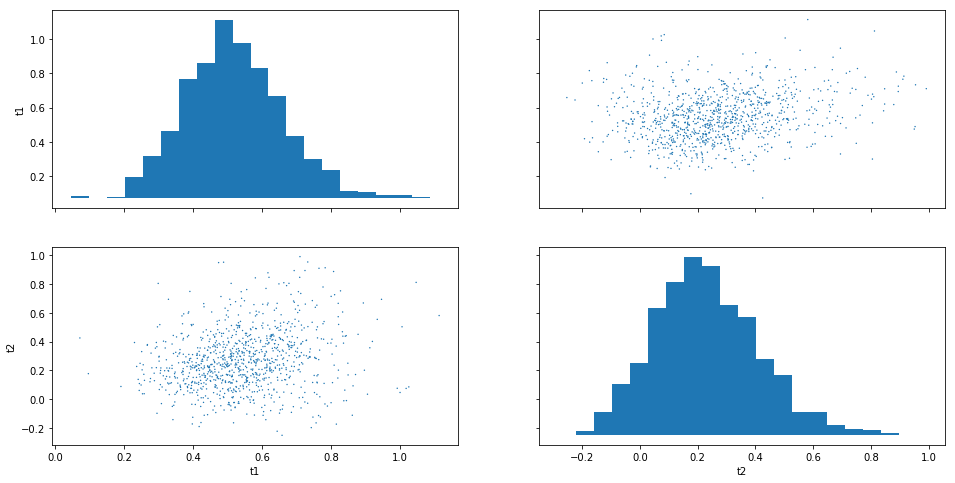

In [15]:
# Print the summary
result3.summary()

import matplotlib.pyplot as plt
result3.plot_pairs();
plt.show()

However, a simpler solution to cases like this may be to define your functions in external scripts (see `elfi.examples.ma2`) and have the module files be available in the folder where you run your ipyparallel engines.

### Remember to stop the ipcluster when done

In [16]:
!ipcluster stop

2018-04-24 19:14:56.997 [IPClusterStop] Stopping cluster [pid=39639] with [signal=<Signals.SIGINT: 2>]
